# Mentoria Diplomatura en Ciencia de Datos 2020
# Aplicacion de ML sobre informacion georeferenciada
## Analisis de calidad de suministro electrico

### Descripcion del dataset

El dataset presentado contiene informacion sobre infraestructura y consumo electrico de la distribuidora SULGIPE en Brasil.
La informacion se encuentra separada en diferentes tablas, la documentacion especificando la estructura y formato de los datos se encuentra en la carpeta 'Docs'.

## 1 -Lectura de datos
Para la lectura y manipulacion de datos georeferenciados utilizaremos la libreria GeoPandas.

In [2]:
# Instalacion GeoPandas con Conda
# !conda install geopandas

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [42]:
from IPython.display import Image

import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

In [5]:
data_path = './data/SULGIPE_46_2018-12-31_M10_20190611-1750.gdb'

In [6]:
# Carguemos la tabla de consumidores de baja tension denominada UCBT
ucbt = gpd.read_file(data_path, driver='FileGDB', layer='UCBT')

In [7]:
# Previsualizacion de datos
ucbt.head()

,DIST,PAC,PN_CON,UNI_TR_D,CTMT,UNI_TR_S,SUB,CONJ,MUN,BRR,...,ENE_09,ENE_10,ENE_11,ENE_12,DIC,FIC,SEMRED,DESCR,ARE_LOC,geometry
0,46,UC111674,99151,14_1140342,3_SETMG_1,2_SETMG_1,SETMG,12743,2927002,RIO REAL,...,152.0,139.0,188.0,208.0,6.89,8.0,0,,UB,POINT (-37.93794999789407 -11.48577998935497)
1,46,UC138742,13334,2_1020023,1_SEAUA_1,2_SEAUA_1,SEAUA,15602,2800670,BOQUIM,...,0.0,0.0,0.0,0.0,0.00,0.0,1,,UB,POINT (-37.61681455354875 -11.14516771072124)
2,46,UC72370,100245,5_1050076,7_SEEST_1,1_SEEST_1,SEEST,15602,2802106,BAIRRO ALAGOAS,...,220.0,267.0,216.0,230.0,4.91,3.0,0,,UB,POINT (-37.43794000292877 -11.25492998802849)
3,46,UC73881,210,5_1050076,7_SEEST_1,1_SEEST_1,SEEST,15602,2802106,BAIRRO ALAGOAS,...,95.0,91.0,97.0,91.0,4.91,3.0,0,,UB,POINT (-37.43821999875388 -11.25455998445568)
4,46,UC73886,212,5_1050076,7_SEEST_1,1_SEEST_1,SEEST,15602,2802106,BAIRRO ALAGOAS,...,97.0,141.0,133.0,126.0,4.91,3.0,0,,UB,POINT (-37.43800000299768 -11.25414998893081)


## 2 - Analisis General

Veamos las caracteristicas principales del dataset.

Segun la documentacion las variables que debe contener la tabla son las siguientes.

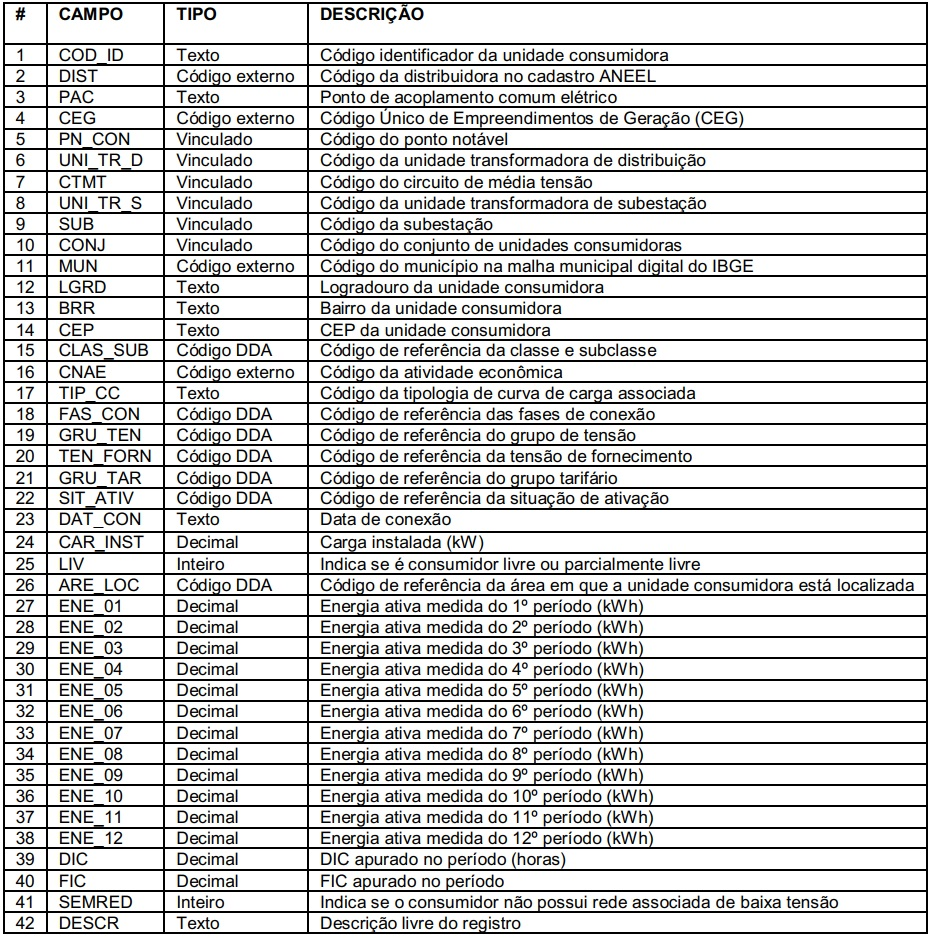

In [8]:
Image(filename='./docs/ucbt_features.jpg') 

In [9]:
# Dimensiones de la tabla
ucbt.shape

(148801, 40)

In [10]:
# Listado de Columnas
ucbt.columns

Index(['DIST', 'PAC', 'PN_CON', 'UNI_TR_D', 'CTMT', 'UNI_TR_S', 'SUB', 'CONJ',
       'MUN', 'BRR', 'CEP', 'CLAS_SUB', 'CNAE', 'TIP_CC', 'FAS_CON', 'GRU_TEN',
       'TEN_FORN', 'GRU_TAR', 'SIT_ATIV', 'DAT_CON', 'CAR_INST', 'LIV',
       'ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07',
       'ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12', 'DIC', 'FIC',
       'SEMRED', 'DESCR', 'ARE_LOC', 'geometry'],
      dtype='object')

### Seleccion de variables
Para esta practico utilizaremos solo las siguientes columnas

In [11]:
col_sel = ['PAC', 'CONJ', 'MUN', 'BRR', 'CLAS_SUB', 'CNAE', 
 'FAS_CON', 'GRU_TEN', 'TEN_FORN', 'GRU_TAR', 'DAT_CON', 'CAR_INST',
 'ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07',
 'ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12', 'ARE_LOC', 
 'DIC', 'FIC']

In [12]:
data = ucbt[col_sel]

Verifiquemos si los tipos de datos se corresponden a los valores especificados

In [13]:
data.dtypes

PAC          object
CONJ          int64
MUN          object
BRR          object
CLAS_SUB     object
CNAE         object
FAS_CON      object
GRU_TEN      object
TEN_FORN     object
GRU_TAR      object
DAT_CON      object
CAR_INST    float64
ENE_01      float64
ENE_02      float64
ENE_03      float64
ENE_04      float64
ENE_05      float64
ENE_06      float64
ENE_07      float64
ENE_08      float64
ENE_09      float64
ENE_10      float64
ENE_11      float64
ENE_12      float64
ARE_LOC      object
DIC         float64
FIC         float64
dtype: object

Podemos ver que existen dos variables que no se corresponden al tipo de dato especificado:

    - CONJ es un identificador categorico pero fue interpretado como numero
    - DAT_CON es una fecha pero se reconoce como texto

In [14]:
# Convertimos los identificadores de los conjuntos a strings
data['CONJ'] = data.CONJ.astype(str)

In [15]:
data['DAT_CON'] = pd.to_datetime(data.DAT_CON, dayfirst=True, format='%d/%m/%Y')

### Descripcion estadistica

In [17]:
cat_ft = data.columns[data.dtypes == 'object']
num_ft = data.columns[data.dtypes != 'object']

In [19]:
# Descripcion Variables Numericas
#data[num_ft].describe().T
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CAR_INST,148801.0,33.747667,626.773221,0.01,0.61,7.61,30.00,81936.00
ENE_01,148801.0,121.128332,2403.634067,-436.00,38.00,68.00,103.00,695852.00
ENE_02,148801.0,124.699075,2196.068210,-1228.00,40.00,71.00,107.00,628569.00
ENE_03,148801.0,119.039805,2410.040568,-581.00,38.00,66.00,100.00,699107.00
ENE_04,148801.0,119.387208,2333.439678,-428.00,38.00,68.00,101.00,677483.00
ENE_05,148801.0,116.147996,2429.333738,-674.00,37.00,65.00,97.00,701631.00
ENE_06,148801.0,109.975148,2348.053272,-1478.00,35.00,62.00,94.00,680697.00
ENE_07,148801.0,103.014496,2287.198552,-396.00,33.00,58.00,87.00,633347.00
ENE_08,148801.0,108.450481,2384.775223,-456.00,34.00,60.00,89.00,633347.00
ENE_09,148801.0,112.012964,2291.757024,-256703.00,38.00,65.00,97.00,613034.00


Tenemos casos de energia negativa lo cual inicialmente parece no ser posible.
Otra observacion que podemos realizar es que la distacia interquartil entre tercero y cuarto, es muchisimo mayor que entre las otras. Lo cual parece indicar que hay valores anormalmente altos.

In [21]:
# Descripcion Variables Categoricas
#data[cat_ft].describe().T
data.describe(include='O').T

,count,unique,top,freq
PAC,148801,145433,UC51068,26
CONJ,148801,6,15602,42090
MUN,148801,14,2802106,30785
BRR,148801,706,CENTRO,20614
CLAS_SUB,148801,28,RE1,99475
CNAE,148801,142,0,148046
FAS_CON,148801,9,AN,96082
GRU_TEN,148801,1,BT,148801
TEN_FORN,148801,1,22,148801
GRU_TAR,148801,6,B1,130596


Si queremos ver en detalles la cantidad de valores en cada categorica podemos usar value_counts().

Veamos los tipos de conexion de fase.

In [56]:
data.FAS_CON.value_counts()

AN      96082
BN      21575
CN      12284
ABN     11210
ABCN     5002
BCN      1963
CAN       678
A           6
C           1
Name: FAS_CON, dtype: int64

En la columna unique podemos ver la cantidad de valores diferentes que toma la variable, esto se denomina 'cardinalidad'. Si esta es muy cercana la cantidad de datos indica que practicamente cada entrada posee un valor diferente, por ejemplo podria ser un caso de un ID.
Si la cardinalidad es 1 significa que todos los valores de la variable son el mismo, por lo cual la variable no brinda ninguna informacion.
Otro caso que se puede presentar es que la cardinalidad sea 2 en este caso es similar a una variable booleana.

## 3 - Distribucion estadistica

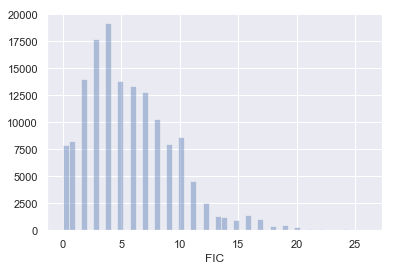

In [55]:
# Distribucion de la Frecuencia de interrupciones
sns.distplot(data.FIC, kde=False)

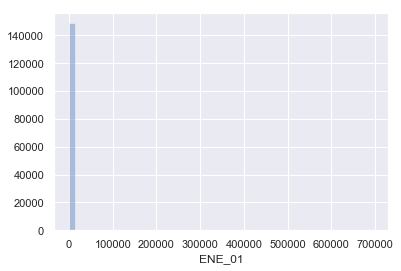

In [96]:
# Distribucion del consumo en enero
sns.distplot(data.ENE_01, kde=False)

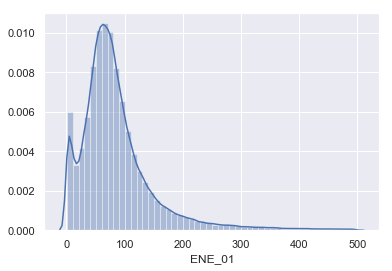

In [97]:
# Podemos ver que todos los valores estan concentrados en la parte baja del rango
# Creemos un filtro para quedarnos con los valores en un rango entre 0 y 500

mask = (data.ENE_01 < 500) & (data.ENE_01 > 0)
sns.distplot(data.ENE_01[mask])

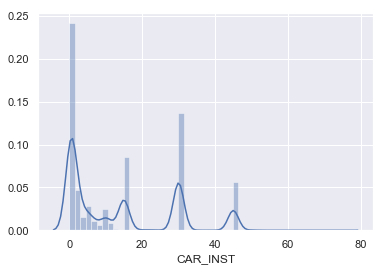

In [174]:
mask = (data.CAR_INST < data.CAR_INST.quantile(.99)) & (data.CAR_INST > 0)
sns.distplot(data.CAR_INST[mask])

### Graficos de interaccion entre variables

Ademas de la distribucion tambien podemos graficar la relacion entre las variables y la salida, o entre ellas.

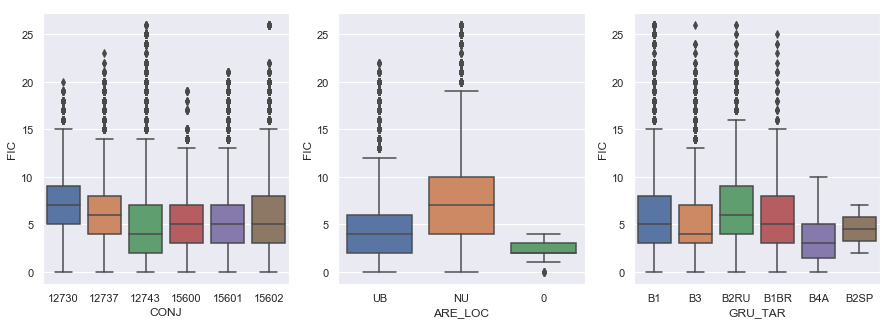

In [118]:
# Para relacionar variables categoricas con una variable numerica podemos usar un BoxPlot
# Boxplot de FIC en base a variables categoricas.

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.boxplot(x= 'CONJ', y='FIC', data=data)

plt.subplot(1,3,2)
sns.boxplot(x= 'ARE_LOC', y='FIC', data=data)

plt.subplot(1,3,3)
sns.boxplot(x= 'GRU_TAR', y='FIC', data=data)

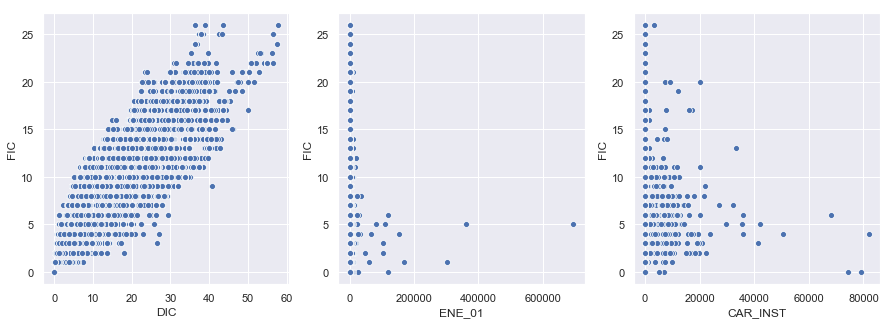

In [129]:
# Para relacionar variables numericas podemos usar un ScatterPlot
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.scatterplot(x= 'DIC', y='FIC', data=data)

plt.subplot(1,3,2)
sns.scatterplot(x= 'ENE_01', y='FIC', data=data)

plt.subplot(1,3,3)
sns.scatterplot(x= 'CAR_INST', y='FIC', data=data)

Una manera rapida de verificar la relacion entre variables es calcular la correlacion.

Que puede ser graficada en un heatmap.

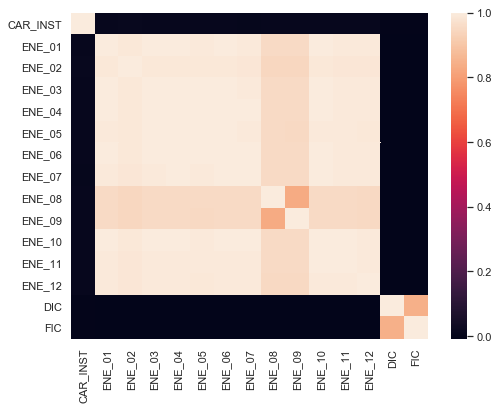

In [136]:
plt.figure(figsize=(8,6))
sns.heatmap(data[num_ft].corr())

Es posible chequear la correspondencia entre variables categoricas haciendo un crosstab para verificar que una categoria no sea una simple subdivision de otra.

In [33]:
# Relacion entre variables categoricas
pd.crosstab(data.CONJ, data.MUN)

MUN,2800407,2800670,2801702,2802106,2802809,2803005,2805109,2805802,2806305,2807402,2807501,2807600,2917904,2927002
CONJ,,,,,,,,,,,,,,
12730,2,0,46,31,6313,0,0,0,2943,1,0,163,2363,0
12737,1,2710,0,4,0,239,0,7683,0,22272,0,0,0,0
12743,0,0,6285,2,2,5,0,1,0,1,5073,0,1706,15390
15600,3190,565,5,1,157,952,3398,1,8,0,0,9482,1,1
15601,6,0,342,0,0,14870,1,0,0,296,153,46,0,0
15602,1217,7594,0,30747,2,1,0,0,2321,0,0,208,0,0


## Conclusion

En esta introduccion hemos aprendido a cargar nuestros datos y a visulizar rapidamente sus principales caracteristicas.
En el proximo paso, utilizaremos estas tecnicas para extraer informacion y responder preguntas.